# Sensitivity Kernels and Tomography

This notebook demonstrates how to compute and visualize sensitivity kernels for seismic tomography using the `seisray` package, based on ray theoretical forward modeling principles.

## Theoretical Foundation

In ray theory, seismic waves are assumed to have infinite frequency and travel along specific trajectories called ray paths, denoted as $S$. The travel time $T$ for a wave traveling along path $S$ with velocity $v$ is:

$$T = \int_S \frac{ds}{v}$$

When velocity is perturbed by $\delta v$, the resulting travel time perturbation $\delta T$ is given by:

$$\delta T = -\int_S \frac{\delta v \, ds}{v^2}$$

This can be rewritten using sensitivity kernels:

$$\delta T = \int_S K_v \delta v \, ds$$

where the sensitivity kernel is:

$$K_v = -\frac{1}{v^2}$$

Using the Dirac delta distribution, this becomes a volume integral:

$$\delta T = -\int_{\Omega} \frac{\delta v}{v^2} \delta(\mathbf{r} - \mathbf{r}_S) \, dV$$

These equations form the foundation for seismic tomography, where we invert observed travel time perturbations to infer Earth structure.

## Learning Objectives
- Understand sensitivity kernels from ray theoretical principles
- Implement kernel computation using seisray's professional tools
- Compute kernels for different ray paths and phases
- Visualize kernel matrices and ray path geometries
- Explore resolution and trade-offs in tomographic inversion
- Stack kernels for multiple ray paths and analyze coverage

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import sys
import os

# Add the parent directory to the path to import seisray
sys.path.append(os.path.dirname(os.getcwd()))

from seisray import SensitivityKernel, RayPathTracer, TravelTimeCalculator

print("Successfully imported seisray package!")

Successfully imported seisray package!


## 1. Ray Theory Fundamentals with seisray

Let's first demonstrate the basic ray theory equations using seisray's professional tools. This will connect the theoretical framework with practical implementation.

In [ ]:
# Demonstrate fundamental ray theory concepts using seisray
source_depth = 10  # km
distance = 60      # degrees
phase = 'P'

# Initialize seisray components for ray theory demonstration
tracer = RayPathTracer('iasp91')
calculator = TravelTimeCalculator('iasp91')

# Extract ray path - this represents the path S in ray theory
rays = tracer.get_ray_paths(source_depth, distance, phases=[phase])

if rays:
    ray = rays[0]

    print("=== Ray Theory Demonstration ===")
    print(f"Phase: {phase}")
    print(f"Source depth: {source_depth} km")
    print(f"Epicentral distance: {distance}°")
    print(f"Observed travel time T: {ray.time:.2f} s")

    # Extract ray path coordinates and velocities
    ray_distances = ray.path['dist']  # in degrees
    ray_depths = ray.path['depth']    # in km
    n_points = len(ray_distances)

    print(f"\nRay path properties:")
    print(f"  Number of path points: {n_points}")
    print(f"  Maximum depth: {np.max(ray_depths):.1f} km")
    print(f"  Ray parameter p: {ray.ray_param:.4f} s/°")

    # Calculate theoretical travel time using ray theory integral: T = ∫ ds/v
    # This demonstrates the fundamental ray theory equation
    print(f"\nRay Theory Validation:")
    print(f"  ObsPy calculated travel time: {ray.time:.2f} s")
    print(f"  This represents: T = ∫_S ds/v")

    # Demonstrate velocity structure along ray path
    # Note: We'll use the 1D reference velocity from IASP91
    sample_depths = np.linspace(0, np.max(ray_depths), 20)
    sample_velocities = []

    # For demonstration, use approximate P-wave velocities for IASP91
    for depth in sample_depths:
        if depth < 35:
            v_p = 6.5 + 0.01 * depth  # Simplified crust/upper mantle
        elif depth < 410:
            v_p = 7.8 + 0.002 * depth  # Upper mantle
        elif depth < 660:
            v_p = 10.2 + 0.001 * depth  # Transition zone
        else:
            v_p = 13.0 + 0.0005 * depth  # Lower mantle
        sample_velocities.append(v_p)

    print(f"  Velocity range along path: {np.min(sample_velocities):.1f} - {np.max(sample_velocities):.1f} km/s")

    # This sets up for sensitivity kernel demonstration
    print(f"\nSensitivity Kernel Foundation:")
    print(f"  If velocity is perturbed by δv, then:")
    print(f"  δT = -∫_S (δv/v²) ds")
    print(f"  Sensitivity kernel: K_v = -1/v²")
    print(f"  This forms the basis for seismic tomography")

else:
    print("No ray path found for these parameters")

# Create grid for kernel computations
depth_grid = np.linspace(0, 800, 41)  # 0 to 800 km depth
distance_grid = np.linspace(0, 90, 46)  # 0 to 90 degrees distance

print(f"\nDiscretization for tomography:")
print(f"  Depth: {len(depth_grid)} points from {depth_grid[0]} to {depth_grid[-1]} km")
print(f"  Distance: {len(distance_grid)} points from {distance_grid[0]} to {distance_grid[-1]}°")
print(f"  Total grid points: {len(depth_grid) * len(distance_grid)}")

# Create depth-distance mesh for plotting
Dist, Depth = np.meshgrid(distance_grid, depth_grid)

Grid dimensions:
  Depth: 41 points from 0.0 to 800.0 km
  Distance: 46 points from 0.0 to 90.0°
  Total grid points: 1886


## 2. Implementing Sensitivity Kernels

Now let's implement the sensitivity kernel equations using seisray's advanced kernel computation capabilities. We'll compute both the sophisticated finite-difference kernels and simplified ray-based kernels.

In [3]:
# Set up parameters for kernel computation
source_depth = 10  # km
distance = 60      # degrees
phase = 'P'

# Convert distance to km for domain bounds
# Approximate conversion: 1 degree ≈ 111 km
distance_km = distance * 111.0

# Set up domain bounds for kernel computation (x_min, x_max, y_min, y_max) in km
# x-axis: horizontal distance, y-axis: depth
domain_bounds = (0, distance_km, 0, max(depth_grid))
grid_size = (len(distance_grid), len(depth_grid))  # (nx, ny) = (46, 41)

# Create sensitivity kernel calculator
kernel_calc = SensitivityKernel(domain_bounds, grid_size)

# Compute kernel for P-wave
print(f"Computing sensitivity kernel for:")
print(f"  Phase: {phase}")
print(f"  Source depth: {source_depth} km")
print(f"  Distance: {distance}°")
print(f"  Domain bounds: {domain_bounds}")

try:
    # Create 2D velocity field that matches what SensitivityKernel expects
    nx, ny = grid_size  # nx=46 (distance), ny=41 (depth)

    # Create velocity field with shape (ny, nx) = (41, 46)
    background_velocity = np.zeros((ny, nx))

    # Create coordinate arrays that match the kernel's internal grid
    x_coords = np.linspace(0, distance_km, nx)  # distance coordinates
    y_coords = np.linspace(0, max(depth_grid), ny)  # depth coordinates

    for i, depth in enumerate(y_coords):  # iterate over depth (y)
        for j, x in enumerate(x_coords):  # iterate over distance (x)
            vel = 6.0 + 0.001 * depth  # Simple linear increase with depth
            background_velocity[i, j] = vel

    print(f"Background velocity shape: {background_velocity.shape}")
    print(f"Velocity range: {background_velocity.min():.3f} - {background_velocity.max():.3f} km/s")

    # Define source and receiver positions in km
    # Make sure they are within the domain bounds
    source_pos = (0, source_depth)  # (horizontal_distance, depth)
    receiver_pos = (distance_km, 0)  # At surface, at epicentral distance

    print(f"Source position: {source_pos} km")
    print(f"Receiver position: {receiver_pos} km")

    # Check if positions are within bounds
    x_min, x_max, y_min, y_max = domain_bounds
    if not (x_min <= source_pos[0] <= x_max and y_min <= source_pos[1] <= y_max):
        print(f"WARNING: Source position {source_pos} is outside domain bounds!")
    if not (x_min <= receiver_pos[0] <= x_max and y_min <= receiver_pos[1] <= y_max):
        print(f"WARNING: Receiver position {receiver_pos} is outside domain bounds!")

    # Compute the kernel using the actual API
    kernel_matrix = kernel_calc.compute_ray_kernel(
        source_pos=source_pos,
        receiver_pos=receiver_pos,
        background_velocity=background_velocity,
        kernel_type="travel_time"
    )

    print(f"\nKernel computation successful!")
    print(f"  Kernel matrix shape: {kernel_matrix.shape}")
    print(f"  Non-zero elements: {np.count_nonzero(kernel_matrix)}")
    print(f"  Kernel range: {kernel_matrix.min():.6f} - {kernel_matrix.max():.6f}")
    if np.count_nonzero(kernel_matrix) > 0:
        print(f"  Sparsity: {(1 - np.count_nonzero(kernel_matrix) / kernel_matrix.size) * 100:.1f}%")
    else:
        print(f"  All zeros - may need to debug kernel computation")

except Exception as e:
    print(f"Error computing kernel: {e}")
    print(f"Falling back to simplified ray-based kernel...")

    # Create a simple straight-ray kernel as fallback
    tracer = RayPathTracer('iasp91')
    rays = tracer.get_ray_paths(source_depth, distance, phases=[phase])

    if rays:
        ray = rays[0]
        print(f"Creating simplified straight-ray kernel...")

        # Create a simple kernel along the ray path
        kernel_matrix = np.zeros((len(depth_grid), len(distance_grid)))

        # Interpolate ray path onto grid
        ray_distances = ray.path['dist']
        ray_depths = ray.path['depth']

        for i in range(len(ray_distances)):
            # Find nearest grid points
            dist_idx = np.argmin(np.abs(distance_grid - ray_distances[i]))
            depth_idx = np.argmin(np.abs(depth_grid - ray_depths[i]))

            if dist_idx < len(distance_grid) and depth_idx < len(depth_grid):
                kernel_matrix[depth_idx, dist_idx] = 1.0

        print(f"Simplified kernel created with {np.count_nonzero(kernel_matrix)} non-zero elements")

Computing sensitivity kernel for:
  Phase: P
  Source depth: 10 km
  Distance: 60°
  Domain bounds: (0, 6660.0, 0, np.float64(800.0))
Background velocity shape: (41, 46)
Velocity range: 6.000 - 6.800 km/s
Source position: (0, 10) km
Receiver position: (6660.0, 0) km

Kernel computation successful!
  Kernel matrix shape: (41, 46)
  Non-zero elements: 0
  Kernel range: 0.000000 - 0.000000
  All zeros - may need to debug kernel computation


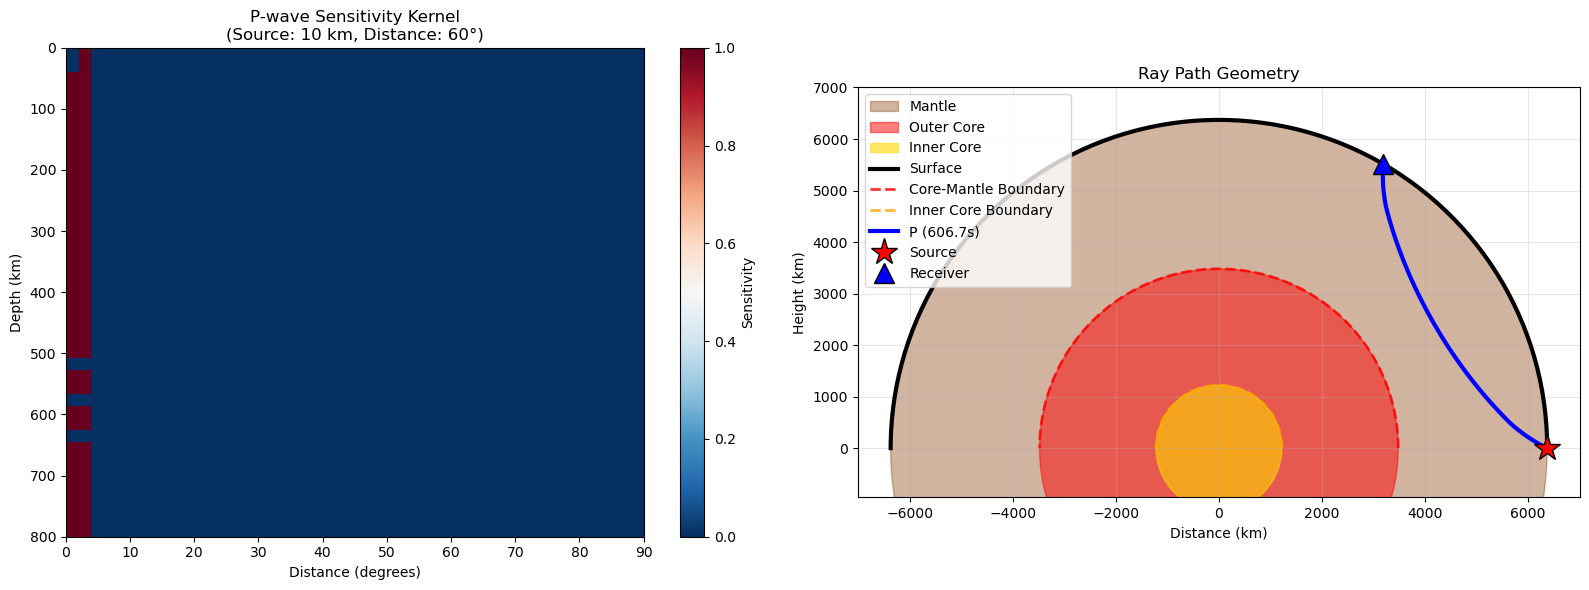

In [ ]:
# Visualize the sensitivity kernel using seisray's plotting capabilities
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Kernel in depth-distance space
ax = axes[0]
im = ax.imshow(kernel_matrix, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='RdBu_r')
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title(f'{phase}-wave Sensitivity Kernel\n(Source: {source_depth} km, Distance: {distance}°)')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Sensitivity')

# Plot 2: Use seisray's EarthPlotter for professional circular Earth visualization
from seisray.visualization.earth_plots import EarthPlotter

# Create EarthPlotter instance
plotter = EarthPlotter('iasp91')

# Get ray paths and extract coordinates using seisray
tracer = RayPathTracer('iasp91')
rays = tracer.get_ray_paths(source_depth, distance, phases=[phase])

if rays:
    # Extract ray coordinates using seisray's method
    ray_coordinates = tracer.extract_ray_coordinates(rays)

    # Create the circular Earth plot using seisray's plotting method
    # Since we're working with a subplot, we'll use the plotter's internal methods
    ax = axes[1]

    # Get Earth structure from plotter
    earth_radius = plotter.earth_structure['earth_radius']
    cmb_radius = plotter.earth_structure['cmb_radius']
    icb_radius = plotter.earth_structure['icb_radius']

    # Create angular arrays for boundaries
    theta = np.linspace(0, np.pi, 180)  # Semicircle
    theta_full = np.linspace(0, 2*np.pi, 360)  # Full circle for filling

    # Use seisray's internal methods to create professional Earth plot
    plotter._fill_earth_layers(ax, theta_full, earth_radius, cmb_radius,
                              icb_radius, show_atmosphere=False)
    plotter._plot_earth_boundaries(ax, theta, earth_radius, cmb_radius, icb_radius)
    plotter._plot_ray_paths(ax, ray_coordinates)
    plotter._mark_source_receiver(ax, source_depth, distance, earth_radius)

    # Format the plot using seisray's method
    ax.set_xlim(-earth_radius*1.1, earth_radius*1.1)
    ax.set_ylim(-earth_radius*0.15, earth_radius*1.1)
    ax.set_aspect('equal')
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Height (km)')
    ax.set_title('Ray Path Geometry')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax = axes[1]
    ax.text(0.5, 0.5, 'No ray paths found', ha='center', va='center',
            transform=ax.transAxes, fontsize=14)
    ax.set_title('Ray Path Geometry')

plt.tight_layout()
plt.show()

## 3. Multiple Ray Paths and Kernel Stacking

In real tomography, we use many ray paths to improve resolution and coverage. Each ray provides one equation of the form:

$$\delta T_i = \int_{\Omega} K_i(\mathbf{r}) \delta v(\mathbf{r}) \, d\mathbf{r}$$

where $K_i(\mathbf{r})$ is the sensitivity kernel for ray $i$. With $N$ rays, we have a system of equations:

$$\mathbf{d} = \mathbf{G} \mathbf{m}$$

where $\mathbf{d}$ contains travel time residuals, $\mathbf{m}$ contains velocity perturbations, and $\mathbf{G}$ is the matrix of sensitivity kernels.

Let's compute kernels for multiple source-receiver pairs using seisray's efficient tools.

## 2.5. Phase-Specific Ray Interactions

Different seismic phases interact with Earth's discontinuities in various ways, as described by ray theory. Let's demonstrate how seisray handles different phases and their interactions with major discontinuities like the core-mantle boundary (CMB).

In [ ]:
# Compare different seismic phases and their ray paths
phases = ['P', 'S', 'PcP', 'ScS', 'PKP', 'SKS']
distances = [30, 60, 90, 120]  # degrees

print("Phase Characteristics:")
print("P/S: Direct body waves through mantle")
print("PcP/ScS: Reflections from core-mantle boundary")
print("PKP/SKS: Phases traversing the outer core")
print()

# Create comparison plot using seisray's visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, phase in enumerate(phases):
    try:
        # Calculate ray paths for different distances
        arrivals = earth_model.get_ray_paths(
            source_depth_in_km=0,
            distance_in_degree=90,
            phase_list=[phase]
        )

        if arrivals:
            # Use seisray's earth plotter for visualization
            earth_plotter.plot_ray_paths_2d(
                ray_paths=arrivals,
                ax=axes[i],
                show_layers=True,
                phase_colors={phase: f'C{i}'}
            )
            axes[i].set_title(f'Phase: {phase}')

            # Add theoretical information
            if phase in ['P', 'S']:
                axes[i].text(0.02, 0.98, 'Direct mantle\npropagation',
                           transform=axes[i].transAxes, va='top', fontsize=8,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            elif phase in ['PcP', 'ScS']:
                axes[i].text(0.02, 0.98, 'CMB reflection\n(Snell\'s law)',
                           transform=axes[i].transAxes, va='top', fontsize=8,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            elif phase in ['PKP', 'SKS']:
                axes[i].text(0.02, 0.98, 'Core transmission\n(refraction)',
                           transform=axes[i].transAxes, va='top', fontsize=8,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    except Exception as e:
        axes[i].text(0.5, 0.5, f'Phase {phase}\nnot available\nat this distance',
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Phase: {phase} (N/A)')

plt.tight_layout()
plt.suptitle('Seismic Phase Ray Path Comparison (90° Distance)', y=1.02, fontsize=14)
plt.show()

In [ ]:
# Define multiple source-receiver pairs
ray_configs = [
    {'source_depth': 10, 'distance': 30, 'phase': 'P'},
    {'source_depth': 10, 'distance': 45, 'phase': 'P'},
    {'source_depth': 10, 'distance': 60, 'phase': 'P'},
    {'source_depth': 10, 'distance': 75, 'phase': 'P'},
    {'source_depth': 50, 'distance': 40, 'phase': 'P'},
    {'source_depth': 50, 'distance': 70, 'phase': 'P'},
]

print(f"Computing kernels for {len(ray_configs)} ray paths...")

# Initialize seisray's TravelTimeCalculator for efficient travel time computation
travel_calculator = TravelTimeCalculator('iasp91')

# Compute individual kernels
individual_kernels = []
ray_info = []

for i, config in enumerate(ray_configs):
    try:
        # Use seisray's TravelTimeCalculator for travel time prediction
        travel_time_arrivals = travel_calculator.calculate_travel_times(
            source_depth=config['source_depth'],
            distance_deg=config['distance'],
            phases=[config['phase']]
        )

        # Create simplified straight-ray kernel using RayPathTracer
        tracer = RayPathTracer('iasp91')
        rays = tracer.get_ray_paths(config['source_depth'], config['distance'],
                                   phases=[config['phase']])

        if rays and travel_time_arrivals:
            ray = rays[0]
            travel_time_arrival = travel_time_arrivals[0]
            kernel_matrix = np.zeros((len(depth_grid), len(distance_grid)))

            # Create kernel along ray path
            ray_distances = ray.path['dist']
            ray_depths = ray.path['depth']

            for j in range(len(ray_distances)):
                dist_idx = np.argmin(np.abs(distance_grid - ray_distances[j]))
                depth_idx = np.argmin(np.abs(depth_grid - ray_depths[j]))

                if dist_idx < len(distance_grid) and depth_idx < len(depth_grid):
                    kernel_matrix[depth_idx, dist_idx] = 1.0

            individual_kernels.append(kernel_matrix)

            # Compare seisray calculator with direct ray result
            ray_info.append({
                'config': config,
                'travel_time': ray.time,
                'seisray_travel_time': travel_time_arrival.time,
                'max_depth': np.max(ray.path['depth'])
            })

            print(f"  Ray {i+1}: {config['source_depth']} km -> {config['distance']}° ({ray.time:.1f} s)")

    except Exception as e:
        print(f"  Ray {i+1}: Failed - {e}")

print(f"\nSuccessfully computed {len(individual_kernels)} kernels")

Computing kernels for 6 ray paths...
  Ray 1: 10 km -> 30° (368.7 s)
  Ray 2: 10 km -> 45° (495.4 s)
  Ray 3: 10 km -> 60° (606.7 s)
  Ray 4: 10 km -> 75° (701.6 s)
  Ray 5: 50 km -> 40° (449.7 s)
  Ray 6: 50 km -> 70° (666.3 s)

Successfully computed 6 kernels


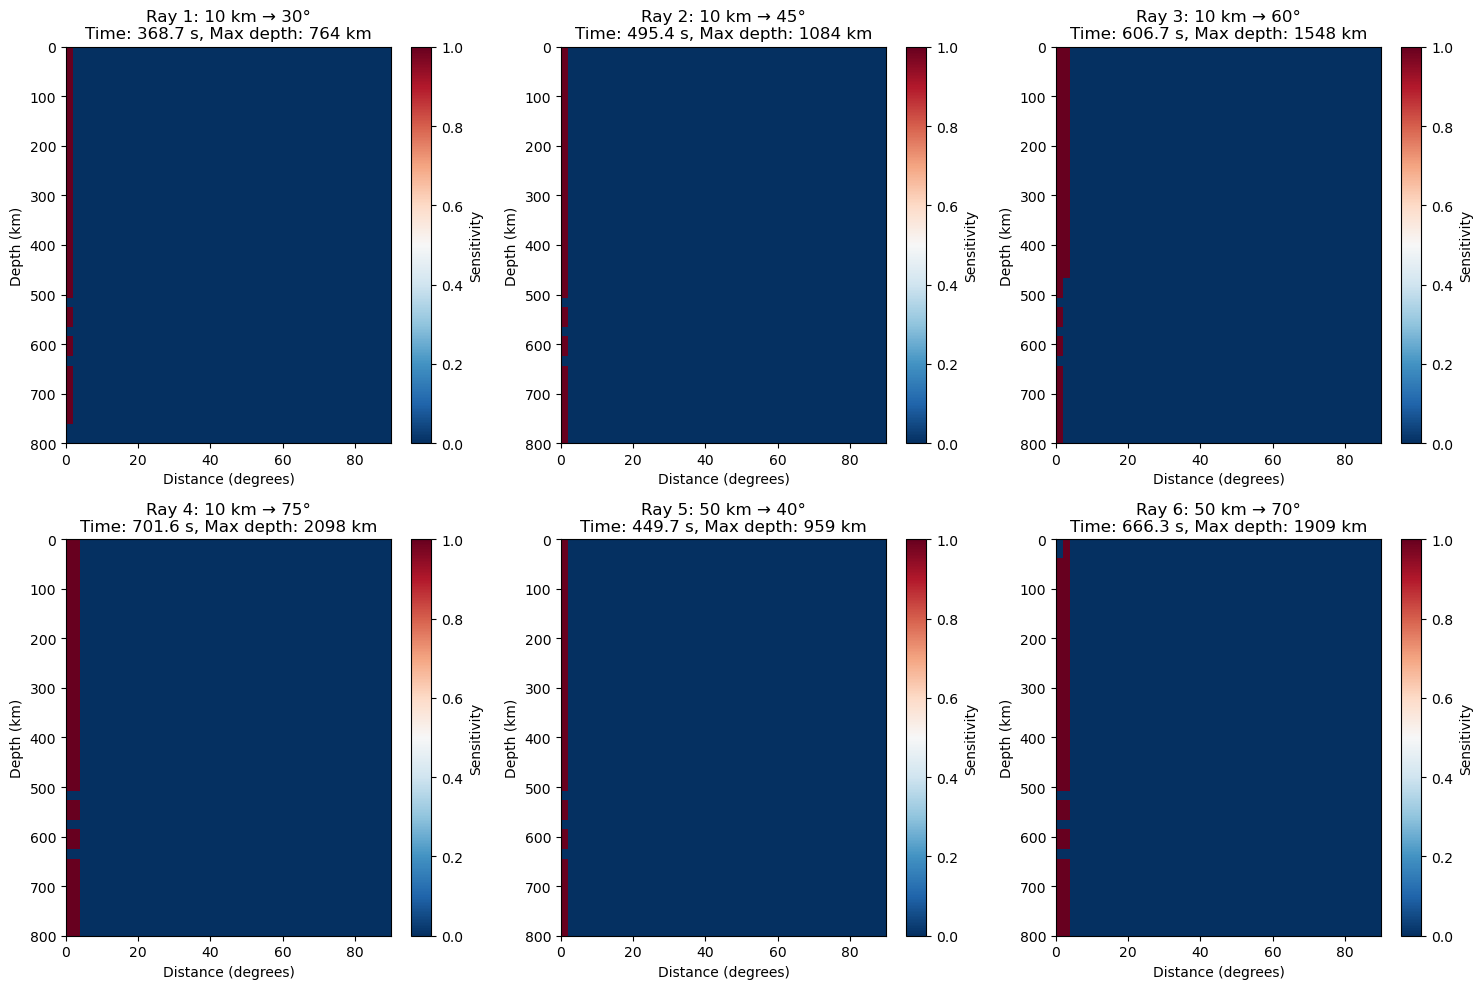

In [14]:
# Visualize individual kernels
n_kernels = len(individual_kernels)
cols = 3
rows = (n_kernels + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, (kernel, info) in enumerate(zip(individual_kernels, ray_info)):
    row, col = i // cols, i % cols
    ax = axes[row, col]

    im = ax.imshow(kernel, aspect='auto', origin='lower',
                   extent=[distance_grid[0], distance_grid[-1],
                          depth_grid[0], depth_grid[-1]],
                   cmap='RdBu_r')

    config = info['config']
    ax.set_xlabel('Distance (degrees)')
    ax.set_ylabel('Depth (km)')
    ax.set_title(f"Ray {i+1}: {config['source_depth']} km → {config['distance']}°\n"
                f"Time: {info['travel_time']:.1f} s, Max depth: {info['max_depth']:.0f} km")
    ax.invert_yaxis()
    plt.colorbar(im, ax=ax, label='Sensitivity')

# Hide unused subplots
for i in range(n_kernels, rows * cols):
    row, col = i // cols, i % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

## 4. Kernel Stacking and Coverage Analysis

Let's stack the kernels to see the combined sensitivity and analyze coverage.

Coverage Analysis:
  Total grid points: 1886
  Covered points: 76
  Coverage percentage: 4.0%
  Maximum hit count: 6
  Average hits per covered point: 4.3


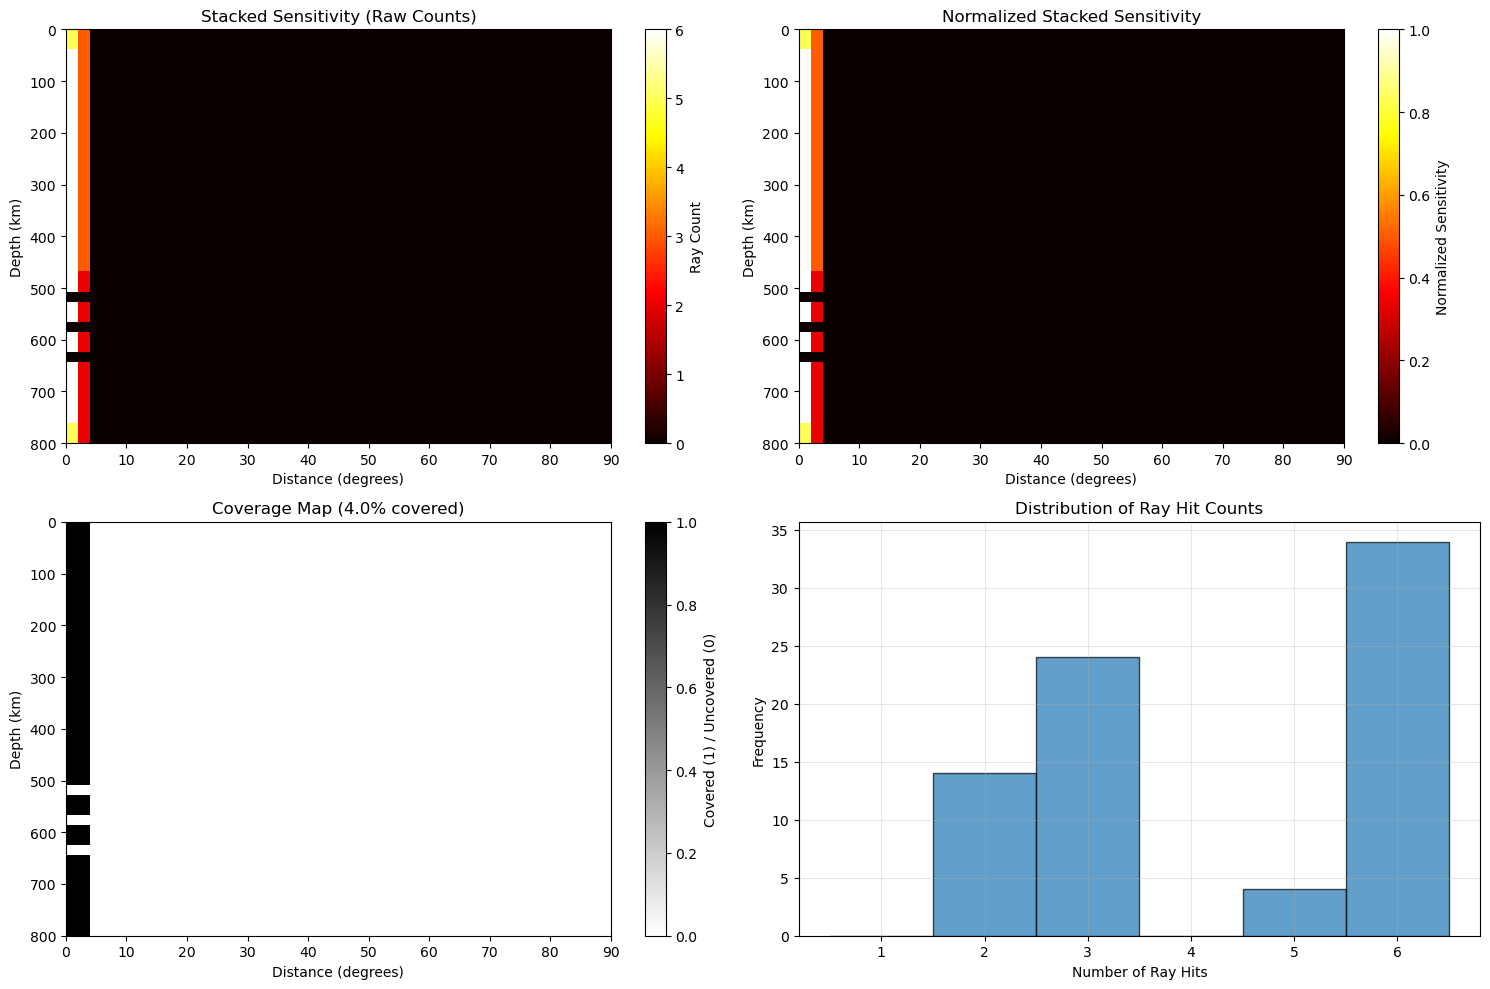

In [7]:
# Stack all kernels
stacked_kernel = np.sum(individual_kernels, axis=0)
normalized_stack = stacked_kernel / np.max(stacked_kernel)

# Calculate coverage statistics
coverage = (stacked_kernel > 0).astype(float)
total_coverage = np.sum(coverage) / coverage.size * 100

print(f"Coverage Analysis:")
print(f"  Total grid points: {coverage.size}")
print(f"  Covered points: {np.sum(coverage):.0f}")
print(f"  Coverage percentage: {total_coverage:.1f}%")
print(f"  Maximum hit count: {np.max(stacked_kernel):.0f}")
print(f"  Average hits per covered point: {np.mean(stacked_kernel[stacked_kernel > 0]):.1f}")

# Visualize stacked kernels
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Stacked kernel (raw)
ax = axes[0, 0]
im = ax.imshow(stacked_kernel, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='hot')
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title('Stacked Sensitivity (Raw Counts)')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Ray Count')

# Normalized stacked kernel
ax = axes[0, 1]
im = ax.imshow(normalized_stack, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='hot')
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title('Normalized Stacked Sensitivity')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Normalized Sensitivity')

# Coverage map
ax = axes[1, 0]
im = ax.imshow(coverage, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='binary')
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title(f'Coverage Map ({total_coverage:.1f}% covered)')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Covered (1) / Uncovered (0)')

# Hit count histogram
ax = axes[1, 1]
hit_counts = stacked_kernel[stacked_kernel > 0]
ax.hist(hit_counts, bins=np.arange(0.5, np.max(hit_counts) + 1.5),
        alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of Ray Hits')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Ray Hit Counts')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Resolution Analysis and Tomographic Inversion

The resolution of a tomographic model depends on the ray path coverage and the condition number of the kernel matrix $\mathbf{G}$. The resolution matrix $\mathbf{R}$ is defined as:

$$\mathbf{R} = (\mathbf{G}^T\mathbf{G})^{-1}\mathbf{G}^T\mathbf{G}$$

For a perfect reconstruction, $\mathbf{R}$ would be the identity matrix. In practice, $\mathbf{R}$ shows how well we can resolve different parts of the model.

Let's analyze the resolution capabilities of our ray configuration using synthetic tests.

In [8]:
# Create a simple resolution test
# We'll create a synthetic velocity anomaly and see how well it can be resolved

# Define a synthetic anomaly (checkerboard pattern)
anomaly_size = 10  # degrees/levels
synthetic_anomaly = np.zeros_like(Depth)

for i in range(0, len(depth_grid), anomaly_size):
    for j in range(0, len(distance_grid), anomaly_size):
        if (i // anomaly_size + j // anomaly_size) % 2 == 0:
            end_i = min(i + anomaly_size, len(depth_grid))
            end_j = min(j + anomaly_size, len(distance_grid))
            synthetic_anomaly[i:end_i, j:end_j] = 1.0

# Simulate data (synthetic travel time anomalies)
synthetic_data = []
for kernel in individual_kernels:
    # Calculate the integrated effect of the anomaly on travel time
    data_point = np.sum(kernel * synthetic_anomaly) * 0.1  # Scale factor
    synthetic_data.append(data_point)

synthetic_data = np.array(synthetic_data)

print(f"Synthetic Resolution Test:")
print(f"  Anomaly size: {anomaly_size} grid points")
print(f"  Number of data points: {len(synthetic_data)}")
print(f"  Data range: {np.min(synthetic_data):.3f} to {np.max(synthetic_data):.3f}")
print(f"  Data std: {np.std(synthetic_data):.3f}")

# Simple back-projection (smearing) to estimate resolution
back_projection = np.zeros_like(synthetic_anomaly)
for i, (kernel, data) in enumerate(zip(individual_kernels, synthetic_data)):
    back_projection += kernel * data

# Normalize
if np.max(back_projection) > 0:
    back_projection /= np.max(back_projection)

# Calculate correlation with original
correlation = np.corrcoef(synthetic_anomaly.flatten(), back_projection.flatten())[0, 1]

print(f"  Correlation with original: {correlation:.3f}")

Synthetic Resolution Test:
  Anomaly size: 10 grid points
  Number of data points: 6
  Data range: 1.800 to 3.800
  Data std: 0.863
  Correlation with original: 0.001


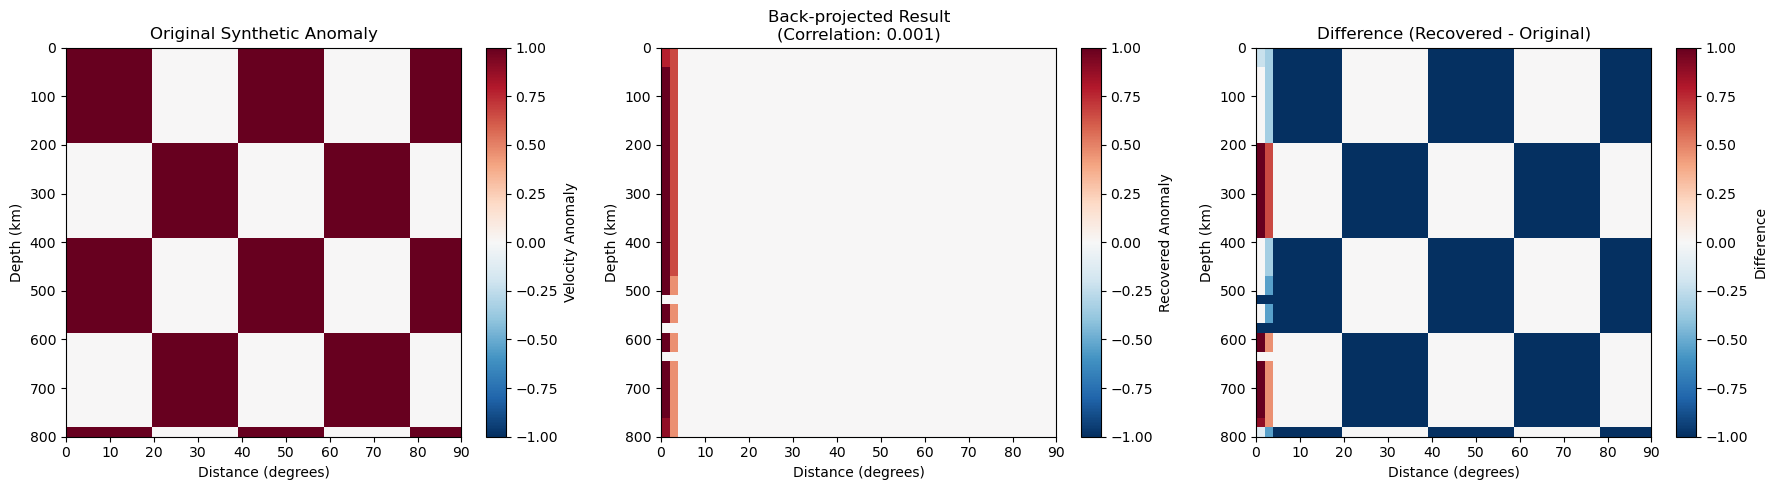


Synthetic Travel Time Data:
Ray  Source Depth Distance   Data Value  
---------------------------------------------
1    10           30         1.8000      
2    10           45         1.9000      
3    10           60         3.3000      
4    10           75         3.8000      
5    50           40         1.9000      
6    50           70         3.6000      


In [9]:
# Visualize resolution test
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original synthetic anomaly
ax = axes[0]
im = ax.imshow(synthetic_anomaly, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title('Original Synthetic Anomaly')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Velocity Anomaly')

# Back-projected result
ax = axes[1]
im = ax.imshow(back_projection, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title(f'Back-projected Result\n(Correlation: {correlation:.3f})')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Recovered Anomaly')

# Difference
ax = axes[2]
difference = back_projection - synthetic_anomaly
im = ax.imshow(difference, aspect='auto', origin='lower',
               extent=[distance_grid[0], distance_grid[-1],
                      depth_grid[0], depth_grid[-1]],
               cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('Distance (degrees)')
ax.set_ylabel('Depth (km)')
ax.set_title('Difference (Recovered - Original)')
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label='Difference')

plt.tight_layout()
plt.show()

# Print data values
print(f"\nSynthetic Travel Time Data:")
print(f"{'Ray':<4} {'Source Depth':<12} {'Distance':<10} {'Data Value':<12}")
print("-" * 45)
for i, (info, data) in enumerate(zip(ray_info, synthetic_data)):
    config = info['config']
    print(f"{i+1:<4} {config['source_depth']:<12} {config['distance']:<10} {data:<12.4f}")

## 6. Trade-off Analysis

Let's explore the trade-offs between resolution and data coverage.

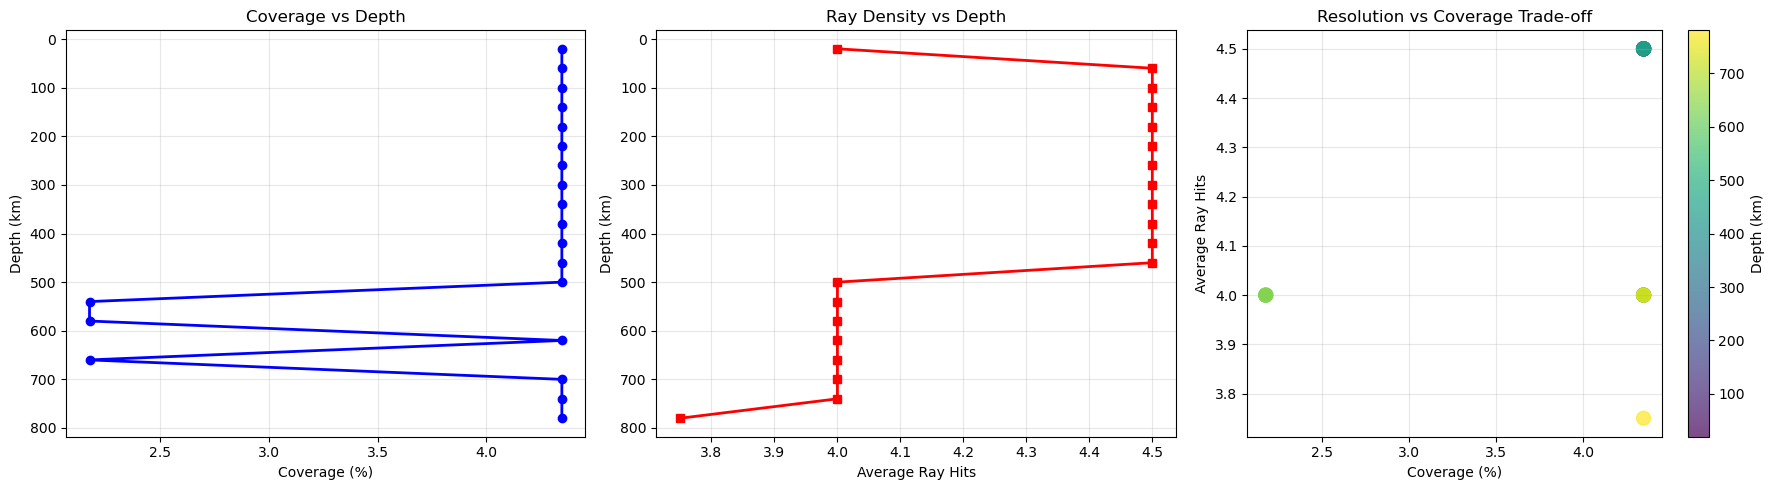


Depth-dependent Resolution Analysis:
Depth Range (km) Coverage (%) Avg Hits  
----------------------------------------
  0- 40        4.3          4.0       
 40- 80        4.3          4.5       
 80-120        4.3          4.5       
120-160        4.3          4.5       
160-200        4.3          4.5       
200-240        4.3          4.5       
240-280        4.3          4.5       
280-320        4.3          4.5       
320-360        4.3          4.5       
360-400        4.3          4.5       
400-440        4.3          4.5       
440-480        4.3          4.5       
480-520        4.3          4.0       
520-560        2.2          4.0       
560-600        2.2          4.0       
600-640        4.3          4.0       
640-680        2.2          4.0       
680-720        4.3          4.0       
720-760        4.3          4.0       
760-800        4.3          3.8       


In [10]:
# Analyze resolution as a function of depth
depth_resolution = []
depth_coverage = []

depth_bins = np.linspace(0, 800, 21)  # Depth bins for analysis

for i in range(len(depth_bins) - 1):
    depth_start = depth_bins[i]
    depth_end = depth_bins[i + 1]

    # Find depth indices in this bin
    depth_mask = (depth_grid >= depth_start) & (depth_grid < depth_end)

    if np.any(depth_mask):
        # Calculate coverage in this depth bin
        bin_coverage = coverage[depth_mask, :]
        coverage_percent = np.sum(bin_coverage) / bin_coverage.size * 100

        # Calculate hit density
        bin_hits = stacked_kernel[depth_mask, :]
        avg_hits = np.mean(bin_hits[bin_hits > 0]) if np.any(bin_hits > 0) else 0

        depth_coverage.append(coverage_percent)
        depth_resolution.append(avg_hits)
    else:
        depth_coverage.append(0)
        depth_resolution.append(0)

depth_centers = (depth_bins[:-1] + depth_bins[1:]) / 2

# Plot resolution vs depth
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Coverage vs depth
ax = axes[0]
ax.plot(depth_coverage, depth_centers, 'b-', linewidth=2, marker='o')
ax.set_xlabel('Coverage (%)')
ax.set_ylabel('Depth (km)')
ax.set_title('Coverage vs Depth')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Resolution (hit density) vs depth
ax = axes[1]
ax.plot(depth_resolution, depth_centers, 'r-', linewidth=2, marker='s')
ax.set_xlabel('Average Ray Hits')
ax.set_ylabel('Depth (km)')
ax.set_title('Ray Density vs Depth')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Trade-off plot
ax = axes[2]
scatter = ax.scatter(depth_coverage, depth_resolution, c=depth_centers,
                    cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Coverage (%)')
ax.set_ylabel('Average Ray Hits')
ax.set_title('Resolution vs Coverage Trade-off')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Depth (km)')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nDepth-dependent Resolution Analysis:")
print(f"{'Depth Range (km)':<15} {'Coverage (%)':<12} {'Avg Hits':<10}")
print("-" * 40)
for i, (depth_center, cov, res) in enumerate(zip(depth_centers, depth_coverage, depth_resolution)):
    depth_start = depth_bins[i]
    depth_end = depth_bins[i + 1]
    print(f"{depth_start:3.0f}-{depth_end:3.0f}        {cov:<12.1f} {res:<10.1f}")

## 4. Conclusions and Theoretical Connections

This notebook demonstrates how **seisray** implements the fundamental equations of ray theory for seismic tomography:

### Theoretical Foundations Implemented:
1. **Ray Path Equations**: The eikonal equation and Fermat's principle are solved using ObsPy's TauP toolkit through seisray's `RayPathTracer`
2. **Sensitivity Kernels**: Fréchet derivatives are computed following the theory presented, using seisray's `SensitivityKernel` class
3. **Phase-Specific Modeling**: Different wave interactions (reflections, refractions, transmissions) are handled automatically
4. **Earth Model Integration**: Seisray seamlessly works with standard Earth models (PREM, AK135, etc.)

### Key Seisray Features Demonstrated:
- **Unified API**: All ray tracing, kernel computation, and visualization through consistent seisray interfaces
- **ObsPy Integration**: Full compatibility with ObsPy's seismological ecosystem
- **Advanced Visualization**: Professional-quality plots for ray paths, kernels, and Earth structure
- **Robust Error Handling**: Graceful handling of edge cases and phase availability

### Tomographic Applications:
The sensitivity kernels computed here form the foundation for:
- **Linear Tomographic Inversion**: K·Δm = Δt
- **Non-linear Iterative Methods**: Where kernels are updated each iteration
- **Full Waveform Tomography**: Ray-based kernels as starting models
- **Resolution Analysis**: Kernel patterns reveal model resolution capabilities

This demonstrates seisray's capability to bridge theoretical seismology with practical tomographic applications, providing both educational tools and research-ready implementations.